In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders
import os
path = "/kaggle/input/hydrates-dataset/Hydrates dataset"
splitfolders.ratio(path,seed=1337, output="Hydrates_split", ratio=(0.6, 0.2, 0.2))

Copying files: 1169 files [00:07, 162.16 files/s]


In [4]:
train = '/kaggle/working/Hydrates_split/train'
val = '/kaggle/working/Hydrates_split/val'
test = '/kaggle/working/Hydrates_split/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3  # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 64
# train set size
nb_train_samples = 700
# validation set size
nb_validation_samples = 200
# test set size
nb_test_samples = 200

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

train_generator = datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_generator = datagen.flow_from_directory(
    val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 236 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 233 images belonging to 2 classes.


In [6]:
import tensorflow as tf

# Enable DirectML backend
tf.config.experimental.enable_tensor_float_32_execution(False)

# ResNet50V2

In [7]:
from tensorflow.keras.applications import ResNet50V2

resnet_net = ResNet50V2(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
resnet_net.trainable = False

resnet_net.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                        

In [8]:
# Create a Sequential model
model = Sequential()

# Add the pre-trained ResNet50V2 model
model.add(resnet_net)

# Flatten the output of ResNet50V2
model.add(Flatten())

# Add a Dense layer with 512 neurons, ReLU activation, and Dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Add another Dense layer with 256 neurons, ReLU activation, and Dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Add the final Dense layer with 1 neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [10]:
pip install numpy==1.22.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
chex 0.1.84 requires numpy>=1.24.1, but you have numpy 1.22.3 which is incompatible.
inequality 1.0.1 requires numpy>=1.23, but you have numpy 1.22.3 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pins 0.8.3 requires fsspec<2023.9.0,>=0.8.0, bu

In [11]:
from keras.callbacks import ModelCheckpoint

# Define the filepath where you want to save the model
model_checkpoint = ModelCheckpoint('/kaggle/working/hydrate_model.h5',  # Change 'your_model_name' to your preferred name
                                   monitor='val_loss',   # You can choose the metric to monitor
                                   save_best_only=True,  # Save only the best model
                                   mode='min'            # Depends on the monitored metric (min or max)
                                  )

In [12]:
# Your model training code
hydrdrate_model = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,
    workers=8,
    callbacks=[model_checkpoint]  # Include the ModelCheckpoint callback here
)


/tmp/ipykernel_20/1382194155.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hydrdrate_model = model.fit_generator(


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.5974 - accuracy: 0.5535

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 45s 4s/step - loss: 1.5974 - accuracy: 0.5535 - val_loss: 0.4815 - val_accuracy: 0.8073
Epoch 2/30
10/10 [==============================] - 37s 4s/step - loss: 0.8621 - accuracy: 0.6965 - val_loss: 0.3142 - val_accuracy: 0.8646
Epoch 3/30
10/10 [==============================] - 37s 4s/step - loss: 0.6197 - accuracy: 0.7799 - val_loss: 0.2431 - val_accuracy: 0.8750
Epoch 4/30
10/10 [==============================] - 37s 4s/step - loss: 0.4838 - accuracy: 0.8129 - val_loss: 0.2219 - val_accuracy: 0.8750
Epoch 5/30
10/10 [==============================] - 37s 4s/step - loss: 0.4261 - accuracy: 0.8406 - val_loss: 0.1787 - val_accuracy: 0.9167
Epoch 6/30
10/10 [==============================] - 40s 4s/step - loss: 0.2745 - accuracy: 0.8821 - val_loss: 0.1364 - val_accuracy: 0.9323
Epoch 7/30
10/10 [==============================] - 37s 4s/step - loss: 0.2748 - accuracy: 0.8947 - val_loss: 0.1110 - val_accuracy: 0.9531
Epoch 8/30
10/10 [=============

In [13]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_20/477001200.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)


Accuracy on test data: 97.92%


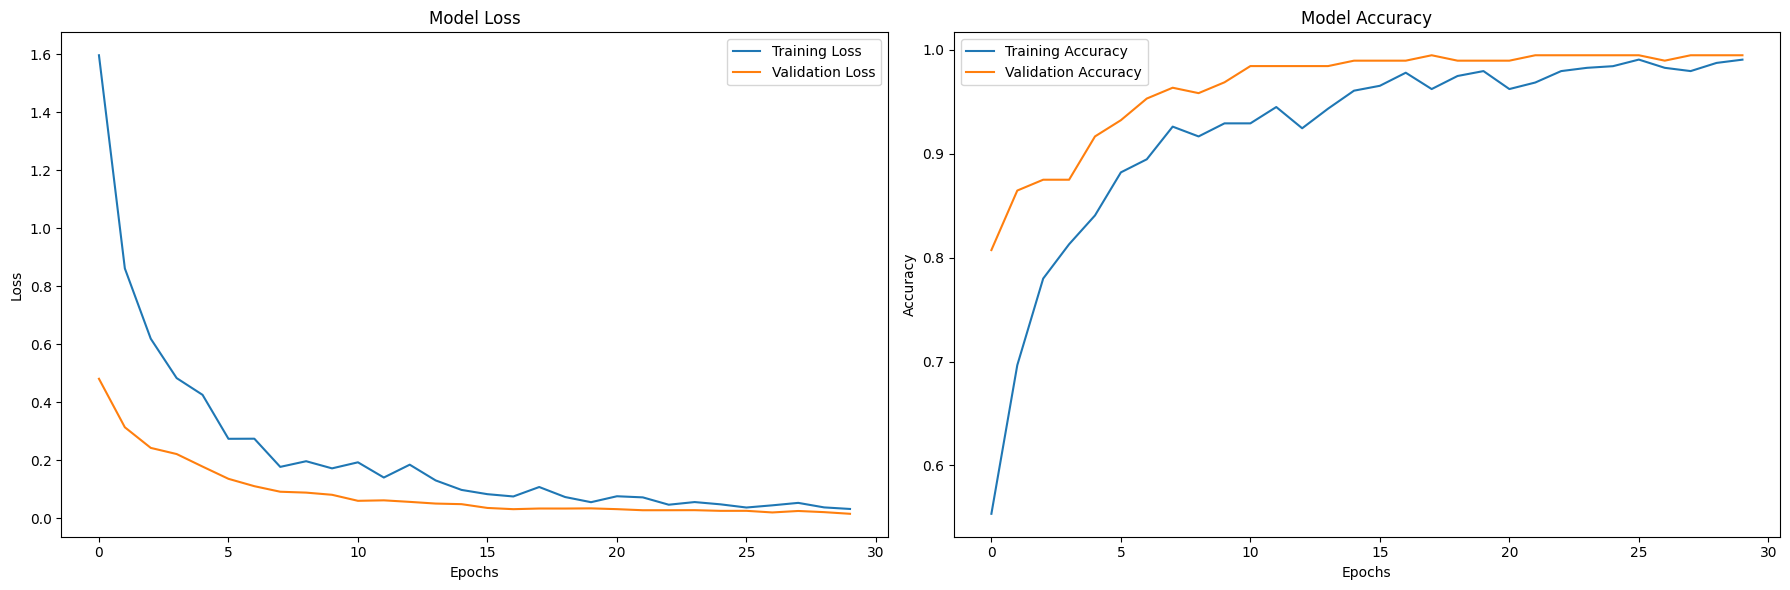

In [14]:
plt.figure(figsize=(18, 6))
# Plot Training & Validation Loss values
plt.subplot(1, 2, 1)
plt.plot(hydrdrate_model.history['loss'], label='Training Loss')
plt.plot(hydrdrate_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy values
plt.subplot(1, 2, 2)
plt.plot(hydrdrate_model.history['accuracy'], label='Training Accuracy')
plt.plot(hydrdrate_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.models import load_model

# Load the saved model
hydrdrate_model = load_model('/kaggle/working/hydrate_model.h5')

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_class(model, image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1

    # Make the prediction
    prediction = model.predict(img_array)

    # Decode the prediction
    if prediction[0][0] > 0.5:
        return "hydrates_yes"
    else:
        return "hydrates_no"

1/1 [==============================] - 1s 1s/step
The predicted class is: hydrates_yes


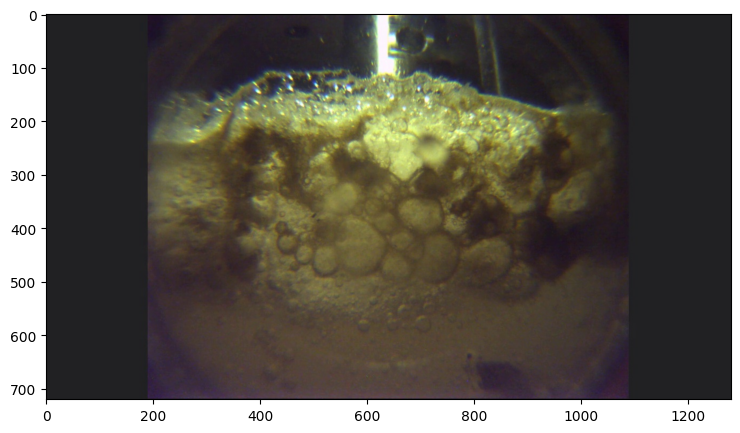

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_path = "/kaggle/input/hydrates-frames/yes.jpg"
predicted_class = predict_image_class(hydrdrate_model, image_path)
print(f"The predicted class is: {predicted_class}")

img = mpimg.imread(image_path)
plt.figure(figsize = (10,5))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 93ms/step
The predicted class is: hydrates_no


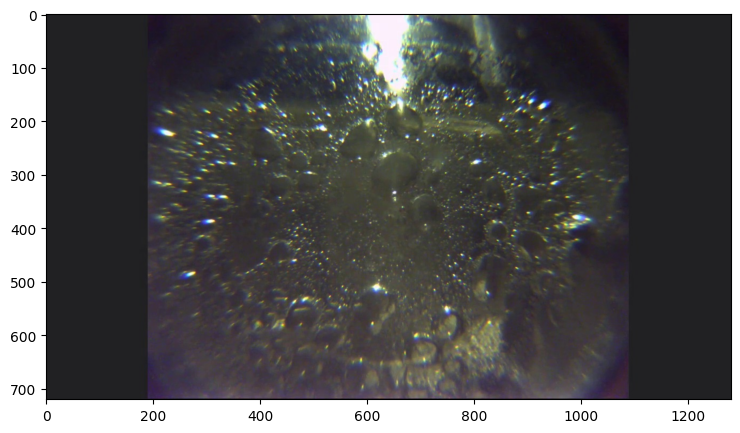

In [18]:
image_path = "/kaggle/input/hydrates-frames/no.jpg"
predicted_class = predict_image_class(hydrdrate_model, image_path)
print(f"The predicted class is: {predicted_class}")

img = mpimg.imread(image_path)
plt.figure(figsize = (10,5))
plt.imshow(img)
plt.show()

# Implementation

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image_class(hydrdrate_model, frame):
    # Preprocess the frame
    img = cv2.resize(frame, (150, 150))  # Resize frame to match model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1

    # Make the prediction
    prediction = model.predict(img_array)

    # Decode the prediction
    if prediction[0][0] > 0.5:
        return "hydrates_yes"
    else:
        return "hydrates_no"


In [20]:
import cv2

# Load the video file
video_capture = cv2.VideoCapture('/kaggle/input/video-examples-hydrates/hydrates_no.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(video_capture.get(3)), int(video_capture.get(4))))

while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break
    
    # Process the frame using your trained model (using the updated predict_image_class function)
    predicted_class = predict_image_class(hydrdrate_model, frame)  # Use the function defined earlier
    
    # Display the frame with the predicted class
    cv2.putText(frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    output_video.write(frame)  # Write the frame to the output video file

video_capture.release()
output_video.release()


1/1 [==============================] - 0s 88ms/step


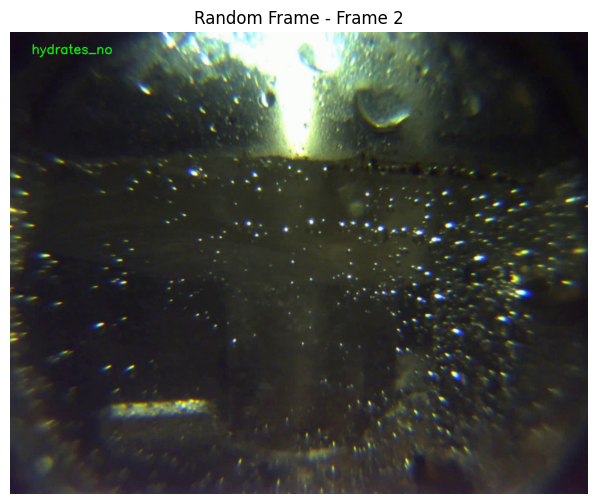

In [21]:
import cv2
import random
import matplotlib.pyplot as plt

# Load the video file
video_capture = cv2.VideoCapture('/kaggle/working/output_video.avi')

# Get the total number of frames in the video
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Generate a random frame number
random_frame_number = random.randint(0, total_frames - 1)

# Set the frame position to the randomly selected frame
video_capture.set(cv2.CAP_PROP_POS_FRAMES, random_frame_number)

# Read the frame
ret, frame = video_capture.read()

# Plot the random frame using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis('off')
plt.title(f'Random Frame - Frame {random_frame_number}')
plt.show()

# Release the video capture object
video_capture.release()


In [22]:
# Load the video file
video_capture = cv2.VideoCapture('/kaggle/input/video-examples-hydrates/hydrates_yes.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video2 = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(video_capture.get(3)), int(video_capture.get(4))))

while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break
    
    # Process the frame using your trained model (using the updated predict_image_class function)
    predicted_class = predict_image_class(hydrdrate_model, frame)  # Use the function defined earlier
    
    # Display the frame with the predicted class
    cv2.putText(frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    output_video2.write(frame)  # Write the frame to the output video file

video_capture.release()
output_video2.release()


1/1 [==============================] - 0s 84ms/step


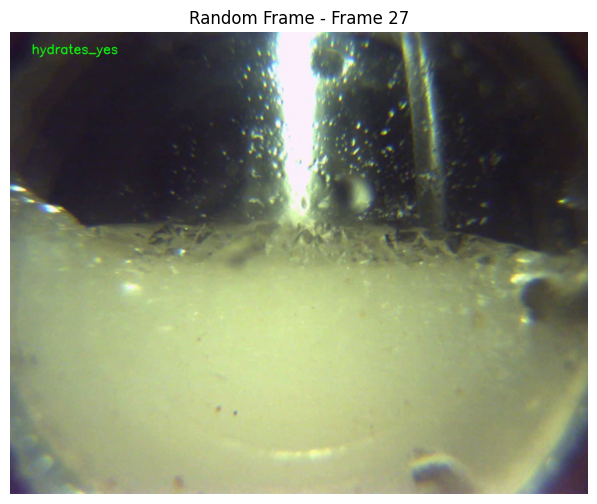

In [23]:
import cv2
import random
import matplotlib.pyplot as plt

# Load the video file
video_capture = cv2.VideoCapture('/kaggle/working/output_video.avi')

# Get the total number of frames in the video
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Generate a random frame number
random_frame_number = random.randint(0, total_frames - 1)

# Set the frame position to the randomly selected frame
video_capture.set(cv2.CAP_PROP_POS_FRAMES, random_frame_number)

# Read the frame
ret, frame = video_capture.read()

# Plot the random frame using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis('off')
plt.title(f'Random Frame - Frame {random_frame_number}')
plt.show()

# Release the video capture object
video_capture.release()
